In [15]:
from typing import Tuple, TypeVar
import numpy as np
from scipy import stats
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import gpflow
from gpflow.utilities import print_summary
from utilities_dpp import (HMCParameters,create_mala_mcmc,load_single_gene_normalized, create_data, load_data, load_single_gene, load_filtered_data, create_standard_mcmc, create_trcd_model, create_premRNA_model,
                       optimize_with_scipy_optimizer, optimize_premRNA, fit_rbf, predict_trcd,
                       plot_trcd_predict, plot_premRNA_predict, select_parameters, optimize_premRNA, init_hyperparameters)

import pymc3
from typing import Callable, List, TypeVar
from trcd.utils import SamplingHelper
gpflow.config.set_default_float(np.float64)   

Scalar = TypeVar("Scalar", tf.Tensor, float)
FullData = Tuple[tf.Tensor, tf.Tensor]
Observations = Tuple[tf.Tensor, tf.Tensor, tf.Tensor]

np.random.seed(100)
tf.random.set_seed(100)

In [2]:
def run_mcmc(run_chain_fn: Callable,
             hmc_helper: SamplingHelper,
             step_size: Scalar):
    # The `traces` object (it can be a tuple or a namedtuple) contains infromation about `log_prob`     values,
    # accept ratios and etc. E.g. you can get `traces.accepted_results.target_log_prob`.

    unconstrained_samples, traces = run_chain_fn(step_size)
    constrained_samples = hmc_helper.convert_to_constrained_values(*unconstrained_samples)

    # NOTE: not used, but useful
    # def assign_unconstrained_sample(index, helper, samples):
    #     subsample = [values[index] for values in samples]
    #     helper.assign_values(*subsample)

    if isinstance(traces.inner_results, tfp.mcmc.nuts.NUTSKernelResults):
        accept_log_probs = traces.inner_results.target_log_prob
        grads = traces.inner_results.grads_target_log_prob
    else:
        accept_log_probs = traces.inner_results.accepted_results.target_log_prob
        grads = traces.inner_results.accepted_results.grads_target_log_prob
    return unconstrained_samples, constrained_samples, accept_log_probs, grads

def run_mala(run_chain_fn: Callable,
             hmc_helper: SamplingHelper,
             step_size: Scalar):
    # The `traces` object (it can be a tuple or a namedtuple) contains infromation about `log_prob`     values,
    # accept ratios and etc. E.g. you can get `traces.accepted_results.target_log_prob`.

    unconstrained_samples = run_chain_fn(step_size)
    #print(unconstrained_samples)
    constrained_samples = hmc_helper.convert_to_constrained_values(*unconstrained_samples)

    # NOTE: not used, but useful
    # def assign_unconstrained_sample(index, helper, samples):
    #     subsample = [values[index] for values in samples]
    #     helper.assign_values(*subsample)

    #if isinstance(traces.inner_results, tfp.mcmc.nuts.NUTSKernelResults):
    #    accept_log_probs = traces.inner_results.target_log_prob
    #    grads = traces.inner_results.grads_target_log_prob
    #else:
    #    accept_log_probs = traces.inner_results.accepted_results.target_log_prob
    #    grads = traces.inner_results.accepted_results.grads_target_log_prob
    return unconstrained_samples, constrained_samples#, accept_log_probs, grads


def analyse_samples(gene_id, tr_id, step_size,parameters_vector , unconstrained_samples: List[tf.Tensor],
                    constrained_samples: List[tf.Tensor],
                    #accept_log_prob: List[tf.Tensor],
                    #grads: List[tf.Tensor],
                    dict_parameters: dict = None,
                    pathname: str = None):
    """
    Plotting and saving graphs on disk.
    """
    path = Path(pathname)
    path.mkdir(exist_ok=True, parents=True)

    parameter_names = list(dict_parameters.keys())
    num_parameters = len(parameter_names)

    num_samples = constrained_samples[0].shape[0]
    x = list(range(num_samples))
    figsize = (30, 20)
    fig, axes = plt.subplots(num_parameters, 2, figsize=figsize)

    for i in range(num_parameters):
        axes[i][0].plot(x, constrained_samples[i])
        axes[i][1].hist(constrained_samples[i], bins='auto', alpha=0.7, rwidth=0.95)
        axes[i][0].title.set_text(parameter_names[i])

    #plt.show()
    plt.savefig(f'{pathname}/'+str(gene_id)+'_'+str(tr_id)+str(step_size)+'_traces.png')

    res = np.zeros((num_parameters, 2))
    for i in range(num_parameters):
        hpd = pymc3.stats.hpd(np.asarray(constrained_samples[i]))
        res[i,0] = hpd[0]
        res[i,1] = hpd[1]
    print(res)

    res = np.concatenate((np.array(parameter_names).reshape(-1,1), np.array(parameters_vector).reshape(-1,1), res), axis=1)

    print(parameter_names)
    df = pd.DataFrame(res)
    #print(df)

    df.columns = ['parameter','MAP','hpd_l', 'hpd_u']

    print(df)
    df.to_csv(f'{pathname}/hpd'+str(gene_id)+'_'+str(tr_id)+str(step_size)+'.csv')


def experiment_print(step: int, msg: str):
    tf.print(f"# [Step {step}] {msg}")


def reset_parameters(parameters: List[gpflow.Parameter], values: List[tf.Tensor]):
    for p, v in zip(parameters, values):
        p.assign(v)

    


## Load the data

In [3]:
data1 = pd.read_csv('LB_GP_TS.csv', sep=",")
data2 = pd.read_csv('Exon_intron_counts_data_normalizedbylibrarydepthonly_20200120.txt',sep=" ")
names_transcripts =  pd.read_csv('zygotic_tr_95_genes.csv', sep=";")

t0 = np.array((95.0,105.0,115.0,125.0,145.0,160.0,175.0,190.0,205.0,220.0))
rep_no = 3
t = np.hstack((t0,t0,t0))[:,None]
t0 = np.array((95.0,105.0,115.0,125.0,145.0,160.0,175.0,190.0,205.0,220.0))

## The gene we are interested in

In [4]:
'''
Gene and transcripts id
'''
gene_id = 'FBgn0033652'
tr_id = 'FBtr0088030'

In [5]:
data, observations, gene_id, data_p, observations_p = load_single_gene(gene_id, tr_id)

## New normalization

mRNA per cell: 193.76; mRNA per TS 27.9; embryo age 175. 

In [6]:
norm_m = 193.76
norm_p = 27.9
time_indexes = np.array([np.where(t == 145)[0],np.where(t == 160)[0],np.where(t == 175)[0]]).flatten()

In [7]:
data, observations, gene_id, data_p, observations_p = load_single_gene_normalized(gene_id, tr_id, time_indexes, norm_m, norm_p)

In [8]:
#data, observations, gene_id, data_p, observations_p = load_single_gene(gene_id, tr_id, time_indexes, norm_m, norm_p)
data_orig, observations_orig, gene_id_orig, data_p_orig, observations_p_orig = load_single_gene(gene_id, tr_id)

## Create and optimize model with fixed S = 1

In [9]:
initial_lengthscale = 10.0
initial_variance = 1.00
initial_S = 1.0

trcd, dict_parameters = create_trcd_model(data, initial_lengthscale, initial_variance, initial_S, transform_base=None)
#dict_parameters = select_parameters(dict_parameters,
#                                    names=None)  # When `names` is None, same dictionary is returned.
trcd.model.kernel.D.assign(0.4)
dict_parameters = select_parameters(dict_parameters,
                                    names=['D','variance','lengthscale','variance_m', 'variance_p'])  # When `names` is None, same dictionary is returned.

# NOTE: WARNING! The order of parameters is quite important here,
# as we pass them around and use same order for plotting and setting titles for plots.
# For that reason we use ordered dictionary.
parameters = list(dict_parameters.values())
# NOTE: Updates TRCD model parameters in place!
res = optimize_with_scipy_optimizer(trcd, parameters)
  

Step 0 loss=5611.99841432666
Step 10 loss=3736.4356363715833
Step 20 loss=3718.013417604318


In [10]:
print_summary(trcd)

╒══════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════╕
│ name                             │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │         value │
╞══════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════╡
│ TRCD.D                           │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │   1.23513e-05 │
│ TRCD.model.kernel.D              │           │             │         │             │         │         │               │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ TRCD.model.kernel.S              │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │   1           │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ TRCD.model.ker

### half-life

In [11]:
np.log(2)/np.asarray(trcd.model.kernel.D.value())

56119.25641484106

predicted y failed, predicted f


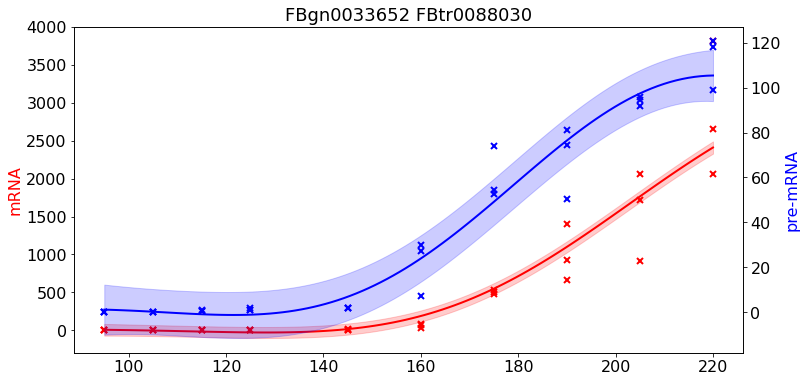

In [12]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations, variance_m, variance_p)

### Run MCMC

In [29]:
# parameters = list(dict_parameters.values())
# parameters
# parameters_vector = tf.stack(parameters)
# parameters_vector

In [30]:
# np.random.seed(100)
# tf.random.set_seed(100)
# from pathlib import Path
# parameters_vector = tf.stack(parameters)
# hmc_parameters = HMCParameters(num_samples=1000, num_burnin_steps=1000)
# hmc_helper, run_chain = create_mala_mcmc(trcd, parameters, hmc_parameters)
# gpflow.config.set_default_positive_minimum(1e-6)
# step_size_mala = np.array([ 10**-5 , 10**-4 , 10**-3 , 0.003, 0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.5, 1])
# for j in range(step_size_mala.shape[0]):
#     step_size = step_size_mala[j]
#     pathname = f"different gene results mala-{step_size}"
#     try:
#         experiment_print(j, "Run MCMC")
#         #num_leapfrog, step_size = leapfrog_num_and_step_size[j]
#         pathname = f"different gene results mala-{step_size}"
#         experiment_print(j, f"Save results at '{pathname}'")

#         samples = run_mala(run_chain,
#                                hmc_helper,
#                                step_size=step_size_mala[j])
#         analyse_samples(gene_id, tr_id, step_size, parameters_vector, *samples, dict_parameters=dict_parameters, pathname=pathname)
#             #reset_parameters(parameters, initial_values)
#         experiment_print(j, f"MCMC finished")
#     except:
#         print('Experiment error')

In [24]:
pathname = f"different gene results mala-{1.0}"
df = pd.read_csv(f'{pathname}/hpd'+str(gene_id)+'_'+str(tr_id)+'1.0'+'.csv')


In [25]:
df

,Unnamed: 0,parameter,MAP,hpd_l,hpd_u
0,0,D,0.000012,1.178515e-09,0.000035
1,1,variance,120.978541,1.180165e+02,123.922160
2,2,lengthscale,41.037981,3.911550e+01,42.983649
3,3,variance_m,765.970516,7.587461e+02,772.763157
4,4,variance_p,14.522686,1.358540e+01,15.503052


### Half-life HPD

In [27]:
np.log(2)/np.asarray(1.178515e-09)

588153040.5297729

In [28]:
np.log(2)/np.asarray(0.000035)

19804.20515885558

## Original data

In [12]:
initial_lengthscale = 10.0
initial_variance = 1.00
initial_S = 1.0

trcd, dict_parameters = create_trcd_model(data_orig, initial_lengthscale, initial_variance, initial_S, transform_base=None)
dict_parameters = select_parameters(dict_parameters,
                                    names=None)  # When `names` is None, same dictionary is returned.
trcd.model.kernel.D.assign(0.4)
#dict_parameters = select_parameters(dict_parameters,
#                                    names=['D','variance','lengthscale','variance_m', 'variance_p'])  # When `names` is None, same dictionary is returned.

# NOTE: WARNING! The order of parameters is quite important here,
# as we pass them around and use same order for plotting and setting titles for plots.
# For that reason we use ordered dictionary.
parameters = list(dict_parameters.values())
# NOTE: Updates TRCD model parameters in place!
res = optimize_with_scipy_optimizer(trcd, parameters)
  

Step 0 loss=382.9840421808686
Step 10 loss=326.4497126490111


In [13]:
print_summary(trcd)

╒══════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                             │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │        value │
╞══════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ TRCD.D                           │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │   0.00929044 │
│ TRCD.model.kernel.D              │           │             │         │             │         │         │              │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ TRCD.model.kernel.S              │ Parameter │ Softplus    │ Gamma   │ True        │ ()      │ float64 │   0.568043   │
├──────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ TRCD.model.kernel.vari

### half-life

In [14]:
np.log(2)/np.asarray(trcd.model.kernel.D.value())

74.60862882337264

predicted y failed, predicted f


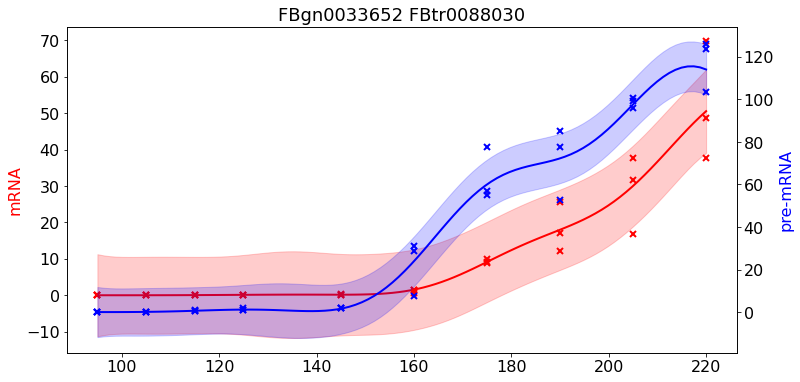

In [15]:
variance_m = np.asarray(trcd.model.likelihood.variance_m.value())
variance_p = np.asarray(trcd.model.likelihood.variance_p.value())
plot_trcd_predict(1, trcd, tr_id, gene_id, observations_orig, variance_m, variance_p)